**Laboratorio N°6 - SIS420**

**Introducción.**

En este cuadernillo, para este laboratorio, nos enfocaremos en el aprendizaje no supervisado, por lo que usaremos el algoritmo *K-Means* para aplicar clustering a un conjunto de datos, de forma que así asignaremos etiquetas a los datos.

**Objetivo.**

Usar el algoritmo K-Means para proporcionar etiquetas detro de un conjunto de datos.

**Declaración de las Librerías.** Primeramente, es necesario declarar cada una de las librerías a usar, así nos enfocaremos cómodamente en el algoritmo.

In [19]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import torch
from torch import optim
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.datasets as datasets
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/gdrive')
%matplotlib inline

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Algoritmo K-means-**

**Funciones para carga y procesamiento del dataset.**

In [20]:
def cargarDataset(_dataset):
  # Función para cargar un conjunto de datos desde un archivo CSV.
  dataset = pd.read_csv(_dataset, sep=';', header=0, decimal=',')
  # Lee el archivo CSV especificado y carga los datos en un DataFrame de pandas.
  movimientos_dataset = dataset['moves'].apply(contar_movimientos).apply(pd.Series)
  # Aplica una función "contar_movimientos" a la columna 'moves' y expande los resultados en nuevas columnas.
  dataset = dataset.join(movimientos_dataset.fillna(0))
  # Combina el DataFrame original con el DataFrame de los movimientos, rellenando los valores nulos con ceros.
  dataset.drop('moves', axis=1, inplace=True)
  # Elimina la columna 'moves' del DataFrame original.
  datos = {}
  # Inicializa un diccionario para almacenar los datos categóricos únicos.
  columnas = dataset.columns[dataset.dtypes == 'object'].tolist()
  # Obtiene una lista de columnas que contienen tipos de datos 'object'.
  for columna in columnas:
    # Itera sobre las columnas cuyos datos son de tipo 'object'.
    datos[columna] = dataset[columna].drop_duplicates().values
    # Obtiene los valores únicos de cada columna y los almacena en el diccionario "datos".
  datos_num = {}
  # Inicializa un diccionario para almacenar los valores categóricos y sus correspondientes valores numéricos.
  for columna, valores in datos.items():
    # Itera sobre las columnas y sus valores únicos.
    indice_reemp = 0
    datos_num_col = {}
    # Inicializa un diccionario para almacenar los valores numéricos correspondientes a los valores categóricos.
    for valor in valores:
      # Itera sobre los valores únicos de la columna.
      if valor not in datos_num_col and not pd.isnull(valor):
        # Si el valor no está presente en el diccionario y no es nulo:
        datos_num_col[valor] = indice_reemp
        indice_reemp += 1
        # Asigna un valor numérico al valor categórico y actualiza el índice.
    if np.nan not in datos_num_col:
      datos_num_col[np.nan] = 0
      # Si no hay un valor numérico asignado para NaN, asigna 0.
    datos_num[columna] = datos_num_col
    # Asigna el diccionario de valores numéricos al diccionario principal.
  for columna, d_n in datos_num.items():
    # Itera sobre las columnas y sus diccionarios de valores numéricos.
    dataset[columna] = dataset[columna].replace(d_n)
    # Reemplaza los valores categóricos con sus equivalentes numéricos en el DataFrame.
  dataset = dataset.fillna(0)
  # Rellena los valores nulos en el DataFrame con ceros.
  return dataset
  # Devuelve el DataFrame procesado.

In [21]:
def contar_movimientos(moves):
    # Función para contar los movimientos en una cadena de movimientos de ajedrez.
    movimientos = moves.split()
    # Divide la cadena de movimientos en una lista de movimientos individuales.
    conteo_movimientos = {}
    # Inicializa un diccionario para almacenar los movimientos contados.
    turno = 1
    jugador = 'W'
    # Inicializa variables para llevar el control del turno y del jugador.
    for movimiento in movimientos:
        # Itera sobre los movimientos en la lista.
        if turno > 64:
            break
            # Rompe el bucle si se alcanza el límite de 32 movimientos.
        clave = f"{turno}{jugador}"
        # Crea una clave única para identificar el movimiento por turno y jugador.
        if clave not in conteo_movimientos:
            conteo_movimientos[clave] = ""
            # Si la clave no existe en el diccionario, inicializa un nuevo espacio.
        conteo_movimientos[clave] += movimiento + " "
        # Añade el movimiento actual al registro correspondiente.
        if jugador == 'W':
            jugador = 'B'
        else:
            jugador = 'W'
            turno += 1
            # Cambia el jugador y actualiza el turno después de cada movimiento.
    return conteo_movimientos
    # Devuelve el diccionario de movimientos contados.

**Funciones para las respectivas gráficas.**

In [22]:
def graficar_fronteras_decision(clusterizador, X, caracteristicas=[8, 9], resolucion=1000, mostrar_centroides=True):
    # Función para graficar las fronteras de decisión de un clusterizador dado y los datos de entrada.
    X_vis = X[:, caracteristicas]
    # Selecciona las características específicas para la visualización.
    minimos = X_vis.min(axis=0) - 1
    maximos = X_vis.max(axis=0) + 1
    # Calcula los límites para la gráfica.
    xx, yy = np.meshgrid(np.linspace(minimos[0], maximos[0], resolucion),
                         np.linspace(minimos[1], maximos[1], resolucion))
    # Crea una malla de puntos para la visualización.
    malla = np.c_[xx.ravel(), yy.ravel()]
    malla_completa = np.zeros((len(malla), clusterizador.n_features_in_))
    malla_completa[:, caracteristicas] = malla
    # Prepara la malla completa para la predicción.
    Z = clusterizador.predict(malla_completa)
    Z = Z.reshape(xx.shape)
    # Realiza la predicción sobre la malla.
    plt.contourf(xx, yy, Z, alpha=0.5, cmap='Pastel2')
    plt.contour(xx, yy, Z, linewidths=1, colors='k')
    # Grafica las fronteras de decisión.
    plt.scatter(X_vis[:, 0], X_vis[:, 1], c=clusterizador.labels_, s=1)
    # Grafica los puntos de datos.
    graficar_datos(X)
    # Llama a la función para graficar los datos originales.
    if mostrar_centroides:
        graficar_centroides(clusterizador.cluster_centers_[:, caracteristicas])
        # Si se especifica, grafica los centroides de los clusters.
def graficar_centroides(centroides, color_circulo='w', color_cruz='k'):
    # Función para graficar los centroides de los clusters.
    plt.scatter(centroides[:, 0], centroides[:, 1],
                marker='o', s=10, linewidths=8,
                color=color_circulo, zorder=10, alpha=0.9)
    plt.scatter(centroides[:, 0], centroides[:, 1],
                marker='x', s=2, linewidths=10,
                color=color_cruz, zorder=11, alpha=1)
    # Grafica los centroides con círculos y cruces.
def graficar_datos(X):
    # Función para graficar los datos originales.
    plt.plot(X[:, 8], X[:, 9], 'k.', markersize=2)
    # Grafica los datos en el espacio de características especificado.
def graficar_clusters(X, y=None):
    # Función para graficar los clusters.
    plt.scatter(X[:, 8], X[:, 9], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)
    # Grafica los clusters con colores específicos (si se proporcionan) y etiqueta los ejes.

**Función para encontrar el mejor número posible de grupos.** La puntuación de Silhouette se utiliza como medida de la calidad de los clusters, donde valores más altos indican una mejor separación entre los clusters.

In [23]:
def encontrar_numero_optimo_grupos(X):
    # Función para encontrar el número óptimo de grupos utilizando el método de Silhouette.
    kmeans_por_k = [KMeans(n_clusters=k, random_state=42).fit(X) for k in range(1, 10)]
    # Entrena modelos KMeans con diferentes números de clusters.
    puntuaciones_silhouette = [silhouette_score(X, modelo.labels_) for modelo in kmeans_por_k[1:]]
    # Calcula la puntuación de Silhouette para cada modelo.
    k_optimo = np.argmax(puntuaciones_silhouette) + 2
    # Encuentra el número óptimo de clusters basado en la puntuación de Silhouette.
    return k_optimo
    # Devuelve el número óptimo de clusters encontrado.

*Este bloque de código carga el conjunto de datos, determina el número óptimo de clusters, aplica el algoritmo KMeans para encontrar los clusters óptimos, grafica los datos originales con los clusters encontrados y muestra las gráficas. Finalmente, asigna las etiquetas de los clusters al conjunto de datos para su posterior análisis.*

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

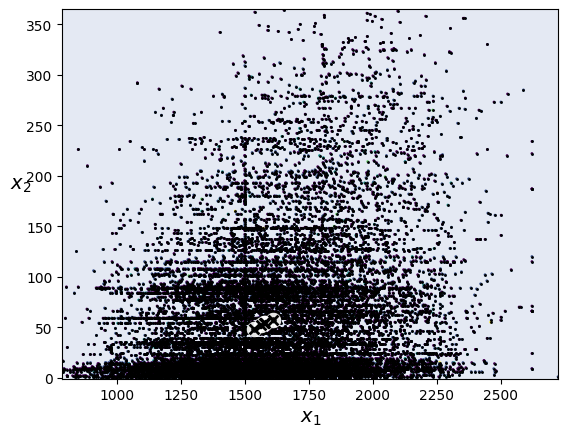

<ipython-input-24-ef3c498c1409>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset['labels'] = y


In [24]:
dataset = cargarDataset('/content/gdrive/MyDrive/SIS420/Laboratorio-N6_-_SIS420/Dataset/games.csv')
# Carga el conjunto de datos desde el archivo 'games.csv' utilizando la función 'cargarDataset'.
k_optimo = encontrar_numero_optimo_grupos(dataset)
# Encuentra el número óptimo de grupos en el conjunto de datos utilizando la función 'encontrar_numero_optimo_grupos'.
kmeans_optimo = KMeans(n_clusters=k_optimo, n_init=10, random_state=42)
# Inicializa un objeto KMeans con el número óptimo de grupos encontrado y otros parámetros.
kmeans_optimo.fit(dataset)
# Aplica el algoritmo KMeans al conjunto de datos para encontrar los grupos óptimos.
graficar_clusters(dataset.values)
# Grafica los datos originales con los clusters encontrados.
graficar_fronteras_decision(kmeans_optimo, dataset.values)
# Grafica las fronteras de decisión para los clusters encontrados.
plt.show()
# Muestra las gráficas.
y = kmeans_optimo.labels_
# Obtiene las etiquetas de los clusters asignadas por KMeans.
dataset['labels'] = y
# Añade las etiquetas de los clusters al conjunto de datos.

# **Prueba del Dataset con sus respectivas etiquetas.**

*Para este cometido se usará la red neuronal del Laboratorio N°5, por lo que los pasos no requieren estar explicados.*

In [25]:
class RedNeuronalMLS(nn.Module):
    def __init__(self, ce, ne):
        super(RedNeuronalMLS, self).__init__()
        co = int(np.sqrt(ce * ne))
        self.capa_oculta = nn.Linear(ce, co)
        self.capa_salida = nn.Linear(co, ne)
    def forward(self, x):
        x = self.capa_oculta(x)
        x = F.sigmoid(x)
        x = self.capa_salida(x)
        return x

In [26]:
def calcularPrecisionModel(loader, modelo):
  num_correct = 0
  num_samples = 0
  modelo.eval()
  predicciones = []
  with torch.no_grad():
      for x, y in loader:
          x = x.to(device=dispositivo)
          y = y.to(device=dispositivo)
          x = x.reshape(x.shape[0], -1)
          scores = modelo(x)
          _, predictions = scores.max(1)
          predicciones.append(predictions)
          num_correct += (predictions == y).sum()
          num_samples += predictions.size(0)
  modelo.train()
  return num_correct/num_samples, predicciones

In [27]:
def calcularPrecisionModel(loader, modelo):
  num_correct = 0
  num_samples = 0
  modelo.eval()
  predicciones = []
  with torch.no_grad():
      for x, y in loader:
          x = x.to(device=dispositivo)
          y = y.to(device=dispositivo)
          x = x.reshape(x.shape[0], -1)
          scores = modelo(x)
          _, predictions = scores.max(1)
          predicciones.append(predictions)
          num_correct += (predictions == y).sum()
          num_samples += predictions.size(0)
  modelo.train()
  return num_correct/num_samples, predicciones

In [28]:
dispositivo = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=99)
X_train, y_train = train_set.iloc[:, :-1], train_set.iloc[:, -1]
X_test, y_test = test_set.iloc[:, :-1], test_set.iloc[:, -1]
X_train = np.concatenate([np.ones((X_train.shape[0], 1)), X_train], axis=1)
X_test = np.concatenate([np.ones((X_test.shape[0], 1)), X_test], axis=1)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.int64)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.int64)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [29]:
caracteristicas_entrada = X_train.shape[1]
numero_etiquetas = len(np.unique(y_train))
tasa_aprendizaje = 0.001
tamaño_lote = 100000
numero_iteraciones = 100
train_loader = DataLoader(train_dataset, batch_size=tamaño_lote, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=tamaño_lote, shuffle=False)

In [30]:
modelo = RedNeuronalMLS(caracteristicas_entrada, numero_etiquetas).to(dispositivo)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelo.parameters(), lr=tasa_aprendizaje)
for epoch in range(numero_iteraciones):
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        data = data.to(device=dispositivo)
        targets = targets.to(device=dispositivo)
        data = data.reshape(data.shape[0], -1)
        scores = modelo(data)
        loss = criterion(scores, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


In [31]:
p_train, pred_train = calcularPrecisionModel(train_loader, modelo)
p_test, pred_test = calcularPrecisionModel(test_loader, modelo)
print(f"Presición en el dataset de entrenamiento: {p_train*100:.2f}")
print(f"Presición en el dataset de prueba: {p_test*100:.2f}")

Presición en el dataset de entrenamiento: 54.47
Presición en el dataset de prueba: 52.94
